# Fitting Multiple Sources in an Image

In this walkthrough, we will show the extension of `pysersic` from a single source to an image with multiple sources. Let's get started with our imports, and loading up one of the example galaxies.

/var/folders/9z/8d9cb1051pb64bnvwp63r4vw0000gn/T/ipykernel_22766/4006701383.py:25: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(im));


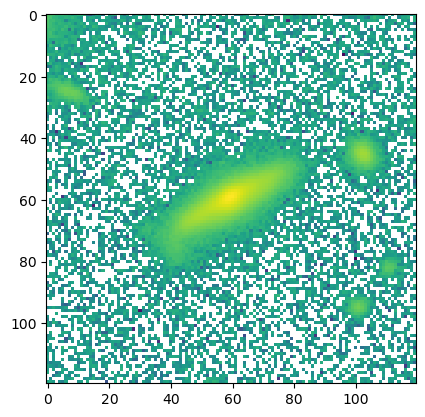

In [3]:
from pysersic import FitSingle,FitMulti, rendering, PySersicResults
from pysersic.results import parse_multi_results
from pysersic.utils.loss import *
from pysersic.priors import generate_sersic_prior, generate_doublesersic_prior,PySersicMultiPrior
import numpy as np
import matplotlib.pyplot as plt
import jax
import corner
import arviz as az
import sep
from jax.random import PRNGKey
import copy
from numpyro.optim import Adam,SGD
from numpyro import infer
from functools import partial
import copy

rkey = PRNGKey(10)

num = 3
im = np.load(f'./examp_gals/gal{num:d}_im.npy')
mask = np.load(f'./examp_gals/gal{num:d}_mask.npy')
psf = np.load(f'./examp_gals/gal{num:d}_psf.npy')
rms = np.load(f'./examp_gals/gal{num:d}_sig.npy')
plt.imshow(np.log10(im));



As we can see, this image has ~5 galaxies of different sizes and shapes. If we were only interested in the central, we could mask the rest. But we can also jointly fit them all.

To begin, we need to construct a `catalog` of sources, with prior guesses for the positions and sizes of each. You can construct catalogs however you like (e.g., from source extractor); here, we'll use the `sep` package to quickly find these sources and catalog them.

In [4]:
#Simple Source Finder to generate catalog
objs,smap = sep.extract(im, 5, err = rms, segmentation_map = True,  deblend_cont=5e-5)
to_pysersic = {}
to_pysersic['flux'] = objs['flux']
to_pysersic['x'] = objs['x']
to_pysersic['y'] = objs['y']
to_pysersic['r'] = objs['a']

type_list = []
for j in range(len(to_pysersic['x'])):
    if to_pysersic['flux'][j] < 30:
        type_list.append('pointsource')
    else:
        type_list.append('sersic')
to_pysersic['type'] = type_list
to_pysersic

{'flux': array([  36.08848572,   83.98748016, 1476.61169434,   10.08358097,
          16.07361984]),
 'x': array([  6.67035738, 102.28865071,  58.83336503, 110.93241678,
        100.73941897]),
 'y': array([25.00044378, 45.36315877, 60.08400813, 81.94876027, 94.75703145]),
 'r': array([3.44829583, 2.63860273, 9.26280499, 1.66357291, 1.72083819]),
 'type': ['sersic', 'sersic', 'sersic', 'pointsource', 'pointsource']}

As we can see, the format of the catalog is a dictionary (or dataframe) with keys `flux`, `x`, `y`, `r`, and `type`. The `type` designation is used to specify the type of fit to perform; for point sources, you can choose the point source option. 

Armed with a catalog, we can now create a `PySersicMultiPrior` object. 

If you are setting the `sky_type` to `None` (that is, not fitting for any sky background), you can proceed with creating the prior. If you *are* fitting the sky, we need to create an estimate for the sky level and rms. 

This can be easily done with the `priors.SourceProperties` class, which is useful for generating autopriors for single source images. We'll make a masked version of our input image to mask everything but the central source, so that we can use pixels around the border to make an estimate of the sky.

In [5]:
from pysersic.priors import SourceProperties 

props = SourceProperties(im,mask=mask)
sky_guess = props.sky_guess 
sky_guess_err = props.sky_guess_err

print(sky_guess)
print(sky_guess_err)

0.015151601
0.07425945


/Users/ipasha/miniconda3/envs/theia/lib/python3.10/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Now that we have our sky estimates, we can create our prior from the catalog, specifying how to fit the sky:

In [6]:
mp = PySersicMultiPrior(catalog = to_pysersic, sky_type='flat',sky_guess=sky_guess,sky_guess_err=sky_guess_err)
print (mp)

PySersicMultiPrior containing 5 sources 

Source 0 : Prior for a sersic source:
--------------------------
flux ---  Normal w/ mu = 36.09, sigma = 12.01
r_eff ---  Truncated Normal w/ mu = 3.45, sigma = 1.86, between: 0.50 -> inf
ellip ---  Uniform between: 0.00 -> 0.90
theta ---  Custom prior of type: <class 'numpyro.distributions.directional.VonMises'>
n ---  Uniform between: 0.50 -> 8.00
xc ---  Normal w/ mu = 6.67, sigma = 1.00
yc ---  Normal w/ mu = 25.00, sigma = 1.00

Source 1 : Prior for a sersic source:
--------------------------
flux ---  Normal w/ mu = 83.99, sigma = 18.33
r_eff ---  Truncated Normal w/ mu = 2.64, sigma = 1.62, between: 0.50 -> inf
ellip ---  Uniform between: 0.00 -> 0.90
theta ---  Custom prior of type: <class 'numpyro.distributions.directional.VonMises'>
n ---  Uniform between: 0.50 -> 8.00
xc ---  Normal w/ mu = 102.29, sigma = 1.00
yc ---  Normal w/ mu = 45.36, sigma = 1.00

Source 2 : Prior for a sersic source:
--------------------------
flux ---  Norma

As we can see, we've now set up priors for each source in our image, as well as the sky. Unlike for the single source (where we can auto-guess these), the values are coming from the catalog file, under the assumption that flux, x,y, and r effective are measured (at least roughly). 

Armed with our prior, we can now create a `FitMulti` object and decide how we are going to proceed with fitting. In this first example, we'll simply find the MAP value, using a `gaussian_mixture` loss function and the `HybridRenderer`. 

In [8]:
fm = FitMulti(data = im, rms= rms, psf = psf, loss_func = gaussian_mixture, prior= mp, renderer=rendering.HybridRenderer)
map_dict = fm.find_MAP()

 10%|▉         | 489/5000 [00:03<00:34, 132.47it/s, Round = 2,step_size = 1.0e-04 loss: -1.880e+04]


We can examine the MAP model:

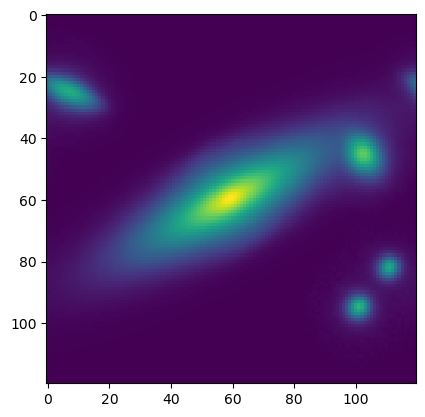

In [11]:
plt.imshow(np.log10(map_dict['model']));

As well as the residual between this model and the data, scaled by the rms:

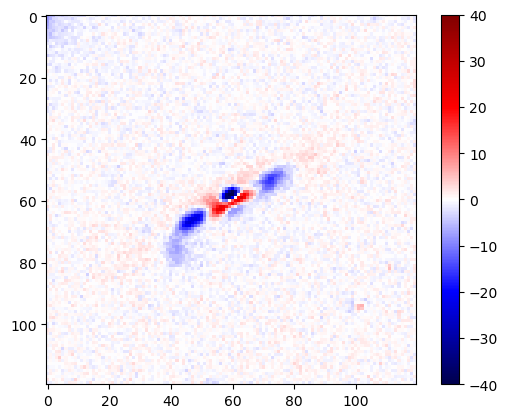

In [17]:
plt.imshow((map_dict['model']-im)/rms,vmin=-40,vmax=40,cmap='seismic')
plt.colorbar()

While most of the sources (besides the central one) are well fit, there's clearly a lot of residual structure for the central source. In this case, these likely represent true deviations from a simple, smooth Sersic profile; in the raw imaging, we can see bulge like structure, for example. 

As for single sources, we can go beyond a MAP estimate and use SVI to estimate the posterior space:

In [18]:
fm.estimate_posterior(method = 'laplace')
res_mp = fm.svi_results
res_mp.summary()

 14%|█▍        | 688/5000 [00:04<00:30, 141.53it/s, Round = 2,step_size = 1.0e-04 loss: -1.879e+04]
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)
arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ellip_0,0.816,0.022,0.775,0.853,0.001,0.000,1015.0,820.0,NaN
ellip_1,0.384,0.019,0.348,0.418,0.001,0.000,981.0,901.0,NaN
ellip_2,0.743,0.002,0.740,0.746,0.000,0.000,811.0,792.0,NaN
flux_0,36.390,2.833,31.287,41.917,0.087,0.062,1055.0,1024.0,NaN
flux_1,86.755,0.839,85.199,88.325,0.027,0.019,951.0,849.0,NaN
flux_2,1446.175,4.341,1438.381,1454.570,0.134,0.095,1042.0,813.0,NaN
flux_3,10.831,0.432,9.983,11.596,0.014,0.010,907.0,900.0,NaN
flux_4,17.138,0.425,16.294,17.927,0.013,0.009,1024.0,1017.0,NaN
n_0,0.659,0.059,0.568,0.770,0.002,0.001,1054.0,981.0,NaN
n_1,1.035,0.072,0.912,1.177,0.002,0.002,958.0,983.0,NaN


The default summary output for for the fit designates the different sources with the format `_X` where `X` is the source number. To single out any particular source, we provide a function `parse_multi_results()`, which allows you to specify one source at a time:

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
xc,59.292,0.011,59.272,59.315,0.000,0.000,1018.0,1015.0,NaN
yc,59.586,0.009,59.570,59.603,0.000,0.000,1045.0,739.0,NaN
flux,1446.175,4.341,1438.381,1454.570,0.134,0.095,1042.0,813.0,NaN
r_eff,7.946,0.037,7.881,8.021,0.001,0.001,1015.0,804.0,NaN
n,1.611,0.014,1.585,1.637,0.000,0.000,926.0,952.0,NaN
ellip,0.743,0.002,0.740,0.746,0.000,0.000,811.0,792.0,NaN
theta,2.649,0.002,2.646,2.653,0.000,0.000,1014.0,984.0,NaN


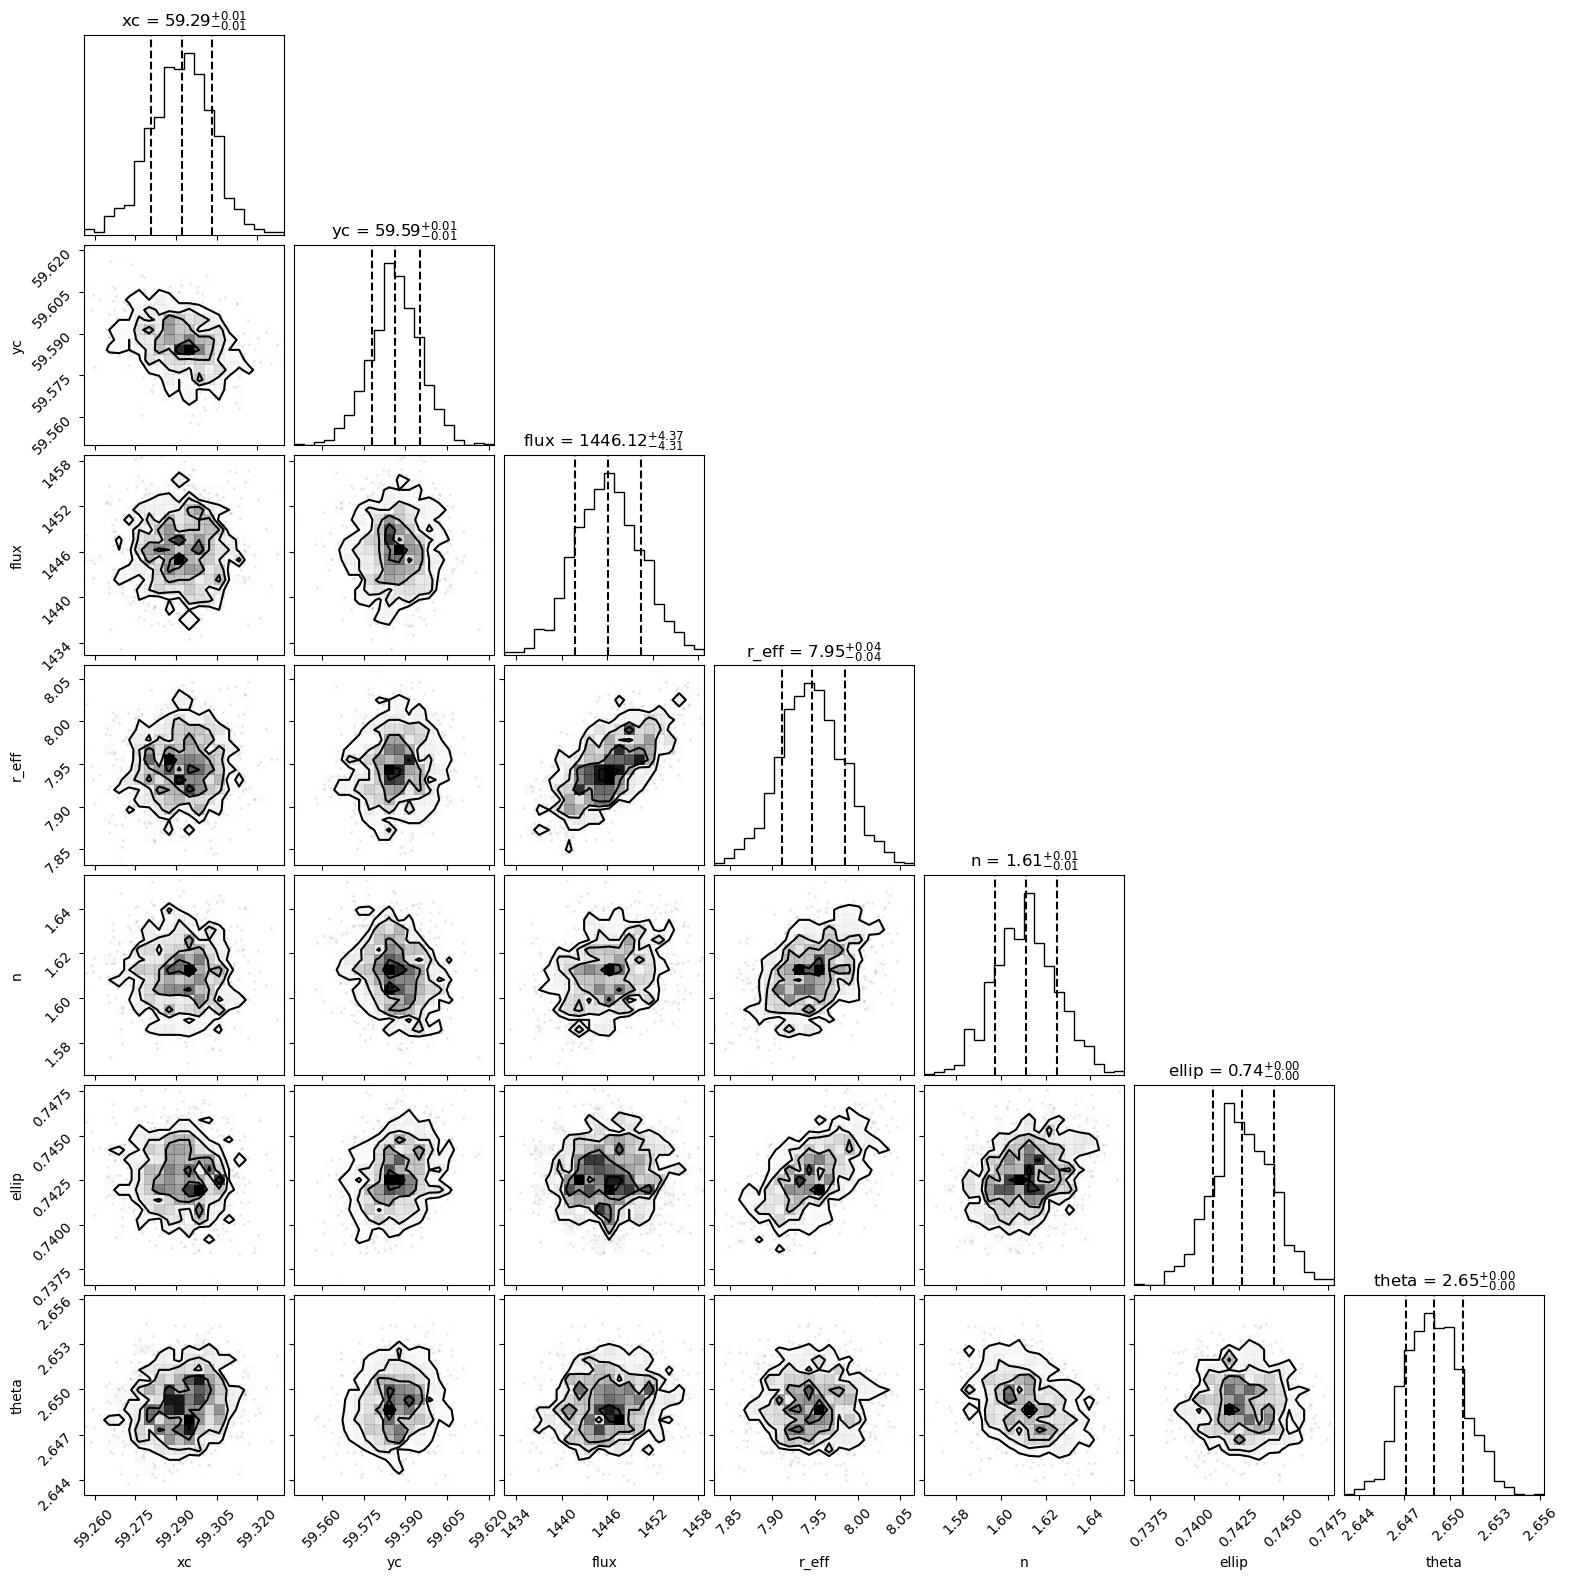

In [19]:
source_res = parse_multi_results(res_mp,2) #extract source with ID 2
source_res.corner()
source_res.summary()

If we now go to extract the chains, we can see that the `idata` property is only for this source:

In [20]:
source_res.idata

Inference data with groups:
	> posterior

To return the full dataset to the `idata` property, you can re-run the parser setting a source index of -1:

In [23]:
source_res = parse_multi_results(source_res,-1) # put everything back

No need to resest posterior, returning original


In [24]:
source_res.idata

Inference data with groups:
	> posterior